In [1]:
# import packages
# sds:2020 Docker environment
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import seaborn as sns
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

import urllib
import json
import requests
import folium
from branca.utilities import split_six

import random
random.seed(42)    # For reproducibility
np.random.seed(42) 

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
tech=pd.read_csv('tech_SIC_geo.csv')

/opt/anaconda3/envs/sds2020/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (3,5,28,41,66) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#select companies with lastest account assets info
tech.sample(3)

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1 registered_number  \
242186      242186       9235105         9235105           6643709   
259580      259580       9807932         9807932           2871505   
152326      152326       6149463         6149463           8362060   

       incorporation_date dissolution_date  latest_accounts_cash  \
242186         2008-07-11              NaN                   nan   
259580         1993-11-12              NaN                   nan   
152326         2013-01-16              NaN                   nan   

        latest_accounts_assets  latest_accounts_liabilities  year_obs  ...  \
242186               27,930.00                    11,959.00      2017  ...   
259580            2,035,619.00                          nan      2017  ...   
152326                1,405.00                          nan      2018  ...   

             laua       ctry        rgn       ttwa        pct       lep1 lep2  \
242186  E06000049  E92000001  E12000002  E30000239  E16000095  E37000003  NaN   
259580  E06000021  E92000001  E12000005  E30000273  E16000119  E37000032  NaN   
152326  E08000035  E92000001  E12000003  E30000229  E16000074  E37000020  NaN   

           oslaua   lat  long  
242186  E06000049 53.26 -2.13  
259580  E06000021 52.99 -2.15  
152326  E08000035 53.80 -1.63  

[3 rows x 70 columns]

In [4]:
#fill na with 0 as it is numerical not categorical that needs dummy variables, 
#it simply indicates there is no high-tech company registered in the area here
#tech = tech.replace(np.nan, 0)
tech = tech.fillna(0)

In [5]:
# not using !=0 as assets filling right should be greater than 0 - only 3 companies with negative
tech_asset = tech[tech["latest_accounts_assets"]>0]

In [6]:
tech_asset.describe()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  latest_accounts_cash  \
count  155,799.00    155,799.00      155,799.00            155,799.00   
mean   157,384.43  6,338,917.17    6,338,917.17              5,586.74   
std     92,279.13  3,129,861.54    3,129,861.54            168,179.23   
min          3.00      5,061.00        5,061.00                  0.00   
25%     74,274.50  3,583,520.50    3,583,520.50                  0.00   
50%    156,205.00  6,294,035.00    6,294,035.00                  0.00   
75%    237,696.50  9,101,189.00    9,101,189.00                  0.00   
max    319,622.00 11,807,537.00   11,807,537.00         54,850,000.00   

       latest_accounts_assets  latest_accounts_liabilities   year_obs  \
count              155,799.00                   155,799.00 155,799.00   
mean               152,912.53                    14,193.05   2,017.16   
std              4,832,663.08                   273,794.77       0.65   
min                      1.00                         0.00   2,011.00   
25%                  8,527.00                         0.00   2,017.00   
50%                 27,238.00                         0.00   2,017.00   
75%                 73,314.50                         0.00   2,017.00   
max          1,638,311,971.00                72,665,866.00   2,018.00   

        sic_year       sic4  change_sic  ...   max_anna  primary_uk_sic_2007  \
count 155,799.00 155,799.00  155,799.00  ... 155,799.00           155,799.00   
mean    2,005.75   6,241.74        0.00  ...       0.99            62,340.79   
std        50.06     896.45        0.00  ...       0.10             7,927.16   
min         0.00       0.00        0.00  ...       0.00            18,201.00   
25%     2,007.00   6,201.00        0.00  ...       1.00            62,012.00   
50%     2,007.00   6,202.00        0.00  ...       1.00            62,020.00   
75%     2,007.00   6,209.00        0.00  ...       1.00            62,090.00   
max     2,007.00   9,999.00        1.00  ...       1.00            74,901.00   

       duo_direct_share  merge_fame       fame  birth_year  diss_year  \
count        155,799.00  155,799.00 155,799.00  155,799.00 155,799.00   
mean              91.51        3.00       1.00    2,009.78       4.58   
std               20.09        0.00       0.00        7.20      96.03   
min                0.00        3.00       1.00    1,874.00       0.00   
25%              100.00        3.00       1.00    2,007.00       0.00   
50%              100.00        3.00       1.00    2,012.00       0.00   
75%              100.00        3.00       1.00    2,015.00       0.00   
max              100.00        3.00       1.00    2,018.00   2,018.00   

             age        lat       long  
count 155,799.00 155,799.00 155,799.00  
mean        7.38      51.98      -1.09  
std         7.15       3.44       1.30  
min         0.00       0.00      -8.09  
25%         3.00      51.45      -1.91  
50%         5.00      51.59      -0.61  
75%        10.00      52.67      -0.14  
max       143.00     100.00       1.76  

[8 rows x 30 columns]

In [7]:
tech_asset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155799 entries, 3 to 319622
Data columns (total 70 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        155799 non-null  int64  
 1   Unnamed: 0.1                      155799 non-null  int64  
 2   Unnamed: 0.1.1                    155799 non-null  int64  
 3   registered_number                 155799 non-null  object 
 4   incorporation_date                155799 non-null  object 
 5   dissolution_date                  155799 non-null  object 
 6   latest_accounts_cash              155799 non-null  float64
 7   latest_accounts_assets            155799 non-null  float64
 8   latest_accounts_liabilities       155799 non-null  float64
 9   year_obs                          155799 non-null  int64  
 10  sic_year                          155799 non-null  float64
 11  sic4                              155799 non-null  f

tech_asset.to_csv("tech_asset.csv")

In [8]:
tech_asset["nr_employees_last_avail_yr"] = pd.to_numeric(tech_asset["nr_employees_last_avail_yr"])

/opt/anaconda3/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
#filter specific industry
#bio 21100 21200 72110
tech_asset_bio = tech_asset[tech_asset["primary_uk_sic_2007"].isin([21100,21200,72110])]

In [10]:
tech_asset_bio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 80 to 319309
Data columns (total 70 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        896 non-null    int64  
 1   Unnamed: 0.1                      896 non-null    int64  
 2   Unnamed: 0.1.1                    896 non-null    int64  
 3   registered_number                 896 non-null    object 
 4   incorporation_date                896 non-null    object 
 5   dissolution_date                  896 non-null    object 
 6   latest_accounts_cash              896 non-null    float64
 7   latest_accounts_assets            896 non-null    float64
 8   latest_accounts_liabilities       896 non-null    float64
 9   year_obs                          896 non-null    int64  
 10  sic_year                          896 non-null    float64
 11  sic4                              896 non-null    float64
 12  chan

tech_asset_bio.to_csv("tech_asset_bio.csv")

In [11]:
#remove missing geo
tech_asset_bio = tech_asset_bio[tech_asset_bio.lat != 0]
tech_asset_bio = tech_asset_bio[tech_asset_bio.latest_accounts_assets > 0]

In [12]:
#a global regression model - GWR, Moran ... in R

In [13]:
from pysal.model import mgwr
import patsy
import contextily as ctx
%matplotlib inline

In [14]:
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
import matplotlib.pyplot as plt
import matplotlib as mpl

In [15]:
def plt_ldn(b):
    fig, ax = plt.subplots(1, figsize=(10, 12))
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

## Mthod 2 gwr

In [16]:
tech_asset_bio4 = tech_asset_bio[['latest_accounts_assets','latest_accounts_liabilities','nr_employees_last_avail_yr','age','oslaua','lat','long']]

In [17]:
#rename column to match
tech_asset_bio4=tech_asset_bio4.rename(columns={"oslaua": "LAD13CD"})

In [18]:
#LAD Geopackage
data = os.path.join('data','geo','localauth.json')
if not os.path.exists(data):
    localauth = gpd.read_file('https://raw.githubusercontent.com/supernovajon/tech-cluster/main/LAD.json')
    print("Downloaded localauth.json file.")
else:
    localauth = gpd.read_file(data)

Downloaded localauth.json file.


In [19]:
rs2 = pd.merge(localauth, tech_asset_bio4, how="right", on=["LAD13CD"])

In [20]:
#Prepare tech_asset_bio dataset inputs
g_y = rs2['latest_accounts_assets'].values.reshape((-1,1))
g_X = rs2[['age', 'nr_employees_last_avail_yr','latest_accounts_liabilities']].values
u = rs2['lat']
v = rs2['long']
g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [21]:
#Calibrate GWR model

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

136.0


#Calibrate MGWR model

mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)
mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

mgwr_results.summary()

In [22]:
#Prepare GWR results for mapping

#Add GWR parameters to GeoDataframe
rs2['gwr_intercept'] = gwr_results.params[:,0]
rs2['gwr_age'] = gwr_results.params[:,1]
rs2['gwr_nr'] = gwr_results.params[:,2]
rs2['gwr_lb'] = gwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

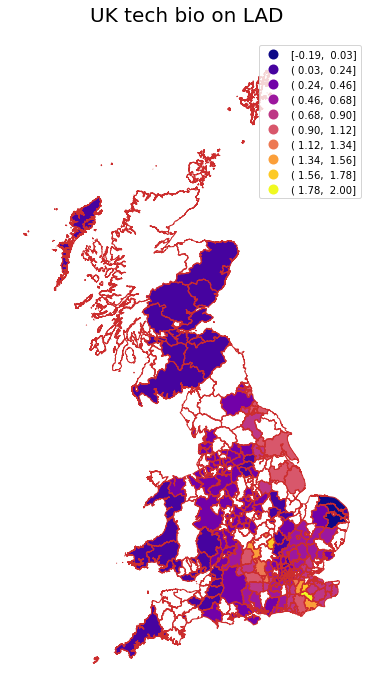

In [23]:
fig, ax = plt_ldn(localauth)
ax.set_axis_off()
ax.set_title('UK tech bio on LAD',fontsize=20, y=1.02)
rs2.plot(column='gwr_nr', ax=ax, linewidth=0, zorder=2,
        legend=True, scheme='equalinterval', edgecolor='k',
        cmap='plasma',k=10)
plt.savefig("age_bio2")
plt.show()

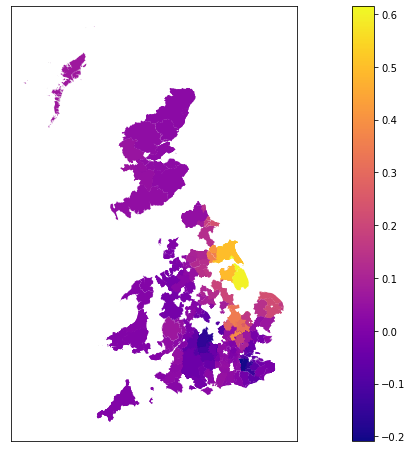

In [24]:
rs2.plot("gwr_age",figsize=(20,8),cmap='plasma',legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig("age_bio")
plt.show()

## local multicollinarity

In [25]:
gwr_selector = Sel_BW(g_coords, g_y, g_X)

In [26]:
gwr_bw = gwr_selector.search()

In [27]:
print(gwr_bw)

128.0


In [28]:
gwr_model = GWR(g_coords, g_y, g_X, gwr_bw)

In [29]:
gwr_results = gwr_model.fit()

In [30]:
rs2.head(10)

LAD13CD LAD13CDO          LAD13NM LAD13NMW  \
0  S12000033     00QA    Aberdeen City     None   
1  S12000033     00QA    Aberdeen City     None   
2  S12000033     00QA    Aberdeen City     None   
3  S12000034     00QB    Aberdeenshire     None   
4  S12000034     00QB    Aberdeenshire     None   
5  E07000241     26UL  Welwyn Hatfield     None   
6  E07000241     26UL  Welwyn Hatfield     None   
7  E07000241     26UL  Welwyn Hatfield     None   
8  E07000241     26UL  Welwyn Hatfield     None   
9  E07000241     26UL  Welwyn Hatfield     None   

                                            geometry  latest_accounts_assets  \
0  MULTIPOLYGON (((-2.07875 57.09302, -2.07942 57...              370,870.00   
1  MULTIPOLYGON (((-2.07875 57.09302, -2.07942 57...                4,337.00   
2  MULTIPOLYGON (((-2.07875 57.09302, -2.07942 57...               12,486.00   
3  MULTIPOLYGON (((-2.31325 56.79981, -2.31325 56...               51,828.00   
4  MULTIPOLYGON (((-2.31325 56.79981, -2.31325 56...              105,110.00   
5  POLYGON ((-0.18357 51.86044, -0.18358 51.86011...              118,993.00   
6  POLYGON ((-0.18357 51.86044, -0.18358 51.86011...            1,950,518.00   
7  POLYGON ((-0.18357 51.86044, -0.18358 51.86011...                    1.00   
8  POLYGON ((-0.18357 51.86044, -0.18358 51.86011...              532,567.00   
9  POLYGON ((-0.18357 51.86044, -0.18358 51.86011...              258,248.00   

   latest_accounts_liabilities  nr_employees_last_avail_yr   age   lat  long  \
0                         0.00                        0.00 10.00 57.14 -2.12   
1                         0.00                        6.00  1.00 57.19 -2.18   
2                         0.00                        1.00  3.00 57.14 -2.12   
3                         0.00                        2.00 16.00 57.07 -2.50   
4                         0.00                        0.00 13.00 57.29 -2.34   
5                         0.00                        0.00  1.00 51.76 -0.23   
6                         0.00                        2.00  2.00 51.76 -0.23   
7                         0.00                        0.00  1.00 51.80 -0.19   
8                         0.00                        9.00  2.00 51.80 -0.20   
9                   239,787.00                       28.00  8.00 51.80 -0.20   

   gwr_intercept  gwr_age  gwr_nr  gwr_lb  
0          -0.12     0.03    0.04    0.26  
1          -0.12     0.03    0.04    0.25  
2          -0.12     0.03    0.04    0.26  
3          -0.12     0.03    0.04    0.25  
4          -0.12     0.03    0.04    0.25  
5          -0.15    -0.00    0.25   -0.59  
6          -0.15    -0.00    0.25   -0.59  
7          -0.15     0.01    0.34   -0.74  
8          -0.14     0.01    0.19   -0.40  
9          -0.14     0.01    0.19   -0.40

In [31]:
rs2.describe()

latest_accounts_assets  latest_accounts_liabilities  \
count                  894.00                       894.00   
mean               475,930.44                    49,377.02   
std              2,491,391.64                   418,663.85   
min                      1.00                         0.00   
25%                  8,820.25                         0.00   
50%                 38,289.00                         0.00   
75%                170,926.00                         0.00   
max             40,022,867.00                 9,017,333.00   

       nr_employees_last_avail_yr    age    lat   long  gwr_intercept  \
count                      894.00 894.00 894.00 894.00         894.00   
mean                         3.43   7.98  52.30  -1.13          -0.03   
std                         14.47   9.77   1.31   1.41           0.11   
min                          0.00   0.00  50.15  -6.87          -0.18   
25%                          0.00   2.00  51.49  -2.05          -0.09   
50%                          0.00   5.00  51.73  -0.77          -0.05   
75%                          2.00  10.00  52.95  -0.12          -0.01   
max                        238.00  71.00  58.22   1.72           0.47   

       gwr_age  gwr_nr  gwr_lb  
count   894.00  894.00  894.00  
mean      0.04    0.47    0.01  
std       0.11    0.31    0.30  
min      -0.21   -0.19   -1.24  
25%      -0.00    0.26   -0.11  
50%       0.02    0.35    0.05  
75%       0.05    0.63    0.16  
max       0.61    2.00    0.71

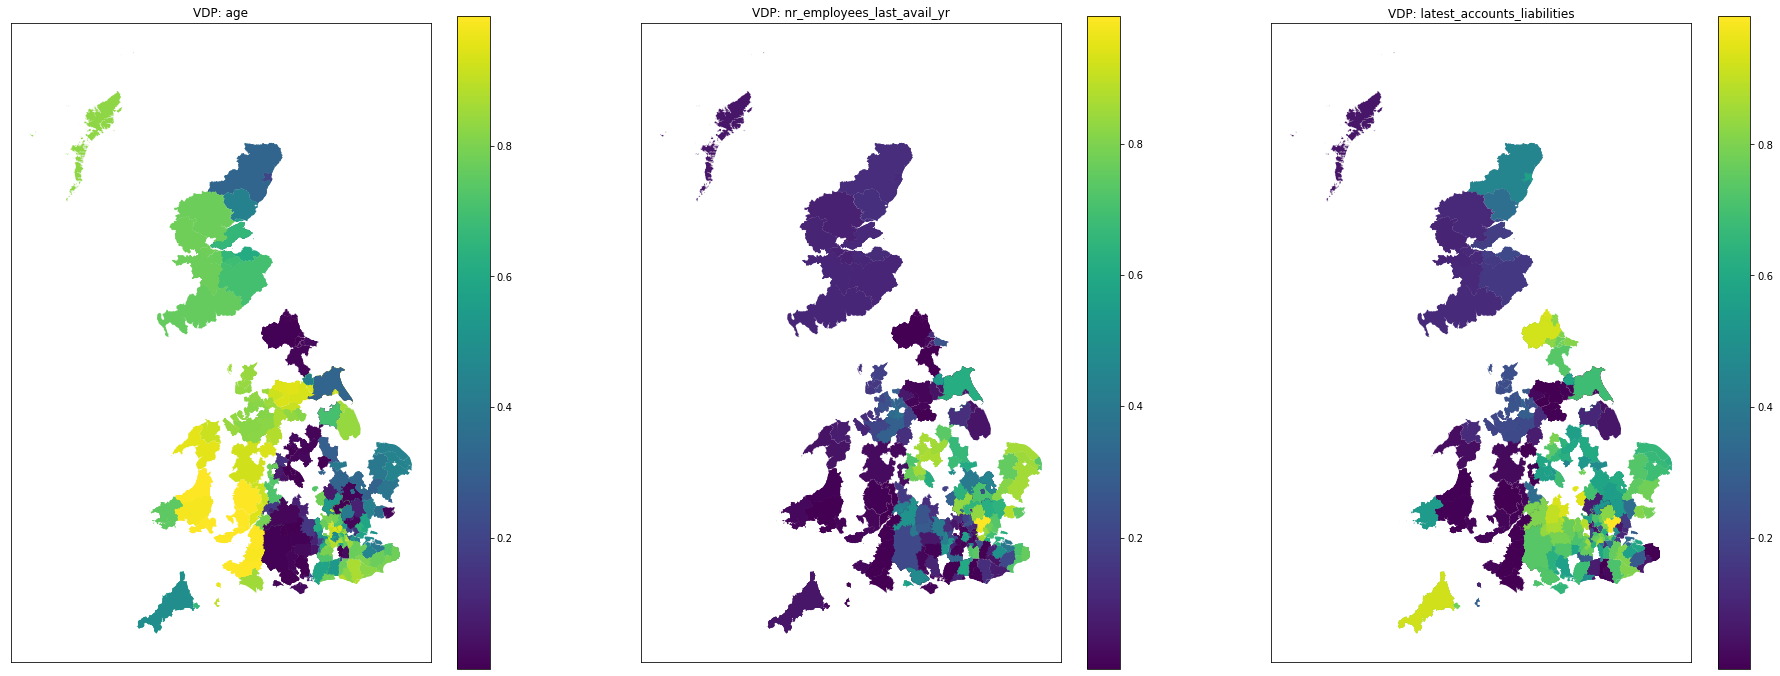

In [32]:
LCC, VIF, CN, VDP = gwr_results.local_collinearity()
names = ["age", "nr_employees_last_avail_yr","latest_accounts_liabilities"]
fig, ax = plt.subplots(1, 3, figsize = (32, 12))
for col in range(3):
    rs2["VDP"] = VDP[:, col]
    rs2.plot("VDP", ax = ax[col], legend = True)
    ax[col].set_title("VDP: " + names[col])
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)
plt.savefig("VDP")
plt.show()

In [33]:
a = LCC.mean()
b = VIF.mean()
c = CN.mean()
d = VDP.mean()

In [34]:
print(a,b,c,d)

0.1662432071882244 1.255163660571647 3.2402281242990667 0.44270902836148324


In [35]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 894
Number of covariates:                                                     4

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            373.769
Log-likelihood:                                                    -878.716
AIC:                                                               1765.433
AICc:                                                              1767.500
BIC:                                                              -5674.409
R2:                                                                   0.582
Adj. R2:                                                              0.581

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

plt.rc('figure', figsize=(5, 3))
plt.text(0.01, 0.05, str(gwr_results.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output.png')

# too long for backfitting
mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi = True)
mgwr_bw = mgwr_selector.search()
print(mgwr_bw)

mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

In [36]:
print(gwr_results.resid_ss)

print(gwr_results.aic)

print(gwr_results.aicc)

print(gwr_results.R2)

177.04524269127128
1232.972823271487
1245.6967014386764
0.8019628157815758


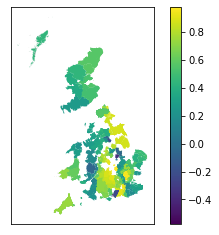

In [43]:
rs2["R2"] = gwr_results.localR2
rs2.plot("R2", legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig("age_R2")
plt.show()

In [37]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn                   # Graphics
import geopandas                 # Spatial data manipulation
import pandas                    # Tabular data manipulation
from pysal.explore import esda   # Exploratory Spatial analytics
from pysal.lib import weights
import contextily                # Background tiles

In [38]:
tech_asset_bio4

latest_accounts_assets  latest_accounts_liabilities  \
1325                370,870.00                         0.00   
2007                  4,337.00                         0.00   
2258                 12,486.00                         0.00   
2359                 51,828.00                         0.00   
2742                105,110.00                         0.00   
...                        ...                          ...   
318607               30,237.00                         0.00   
318859                  899.00                         0.00   
319078                  939.00                         0.00   
319235                1,234.00                    13,439.00   
319309               93,085.00                         0.00   

        nr_employees_last_avail_yr   age    LAD13CD   lat  long  
1325                          0.00 10.00  S12000033 57.14 -2.12  
2007                          6.00  1.00  S12000033 57.19 -2.18  
2258                          1.00  3.00  S12000033 57.14 -2.12  
2359                          2.00 16.00  S12000034 57.07 -2.50  
2742                          0.00 13.00  S12000034 57.29 -2.34  
...                            ...   ...        ...   ...   ...  
318607                        2.00  3.00  E06000014 53.96 -0.98  
318859                        0.00  3.00  E06000011 53.96 -0.53  
319078                        1.00  2.00  E06000014 53.98 -1.11  
319235                        0.00  2.00  E06000014 54.01 -1.06  
319309                        2.00  8.00  E06000011 53.93 -0.78  

[894 rows x 7 columns]

In [56]:
#groupby local authority district
biolad = tech_asset_bio4.groupby(['LAD13CD'])['latest_accounts_assets'].agg(totalasset='sum').reset_index() # oslaua companies grouped counts
biolad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LAD13CD     264 non-null    object 
 1   totalasset  264 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [98]:
cols = biolad.columns.values
cols[0]  = 'LAD13CD'
cols[1]  = 'totalasset'
biolad.columns = cols

In [99]:
len(biolad)

264

In [103]:
gdf = gpd.GeoDataFrame(tech_asset_bio4, 
      geometry=gpd.points_from_xy(tech_asset_bio4['long'], tech_asset_bio4['lat'], crs='epsg:4326'))
#gdf = gdf.to_crs('epsg:27700')

In [110]:
#drop dupilicate
gdf1 = gdf.drop_duplicates(subset=['LAD13CD'])

In [111]:
#add lat long to the tech_SIC
biolad1 = pd.merge(biolad, gdf1, how="left", on="LAD13CD")

In [112]:
biolad1

LAD13CD   totalasset  latest_accounts_assets  \
0    E06000001    45,520.00               45,520.00   
1    E06000002   447,284.00              447,284.00   
2    E06000003   141,368.00              132,753.00   
3    E06000004 1,761,854.00            1,761,854.00   
4    E06000005    25,600.00               23,013.00   
..         ...          ...                     ...   
259  W06000014 1,099,295.00              177,014.00   
260  W06000015   527,539.00                5,108.00   
261  W06000019   164,922.00              135,259.00   
262  W06000021        20.00                   20.00   
263  W06000022    56,834.00                2,008.00   

     latest_accounts_liabilities  nr_employees_last_avail_yr   age   lat  \
0                           0.00                        1.00  1.00 54.69   
1                           0.00                        0.00  2.00 54.56   
2                           0.00                        0.00 25.00 54.58   
3                           0.00                        2.00 11.00 54.63   
4                           0.00                        1.00  3.00 54.52   
..                           ...                         ...   ...   ...   
259                         0.00                        0.00  7.00 51.45   
260                         0.00                        0.00 11.00 51.54   
261                         0.00                       25.00 13.00 51.75   
262                         0.00                        0.00  1.00 51.70   
263                         0.00                        0.00  6.00 51.56   

     long                   geometry  
0   -1.21  POINT (-1.20508 54.68696)  
1   -1.24  POINT (-1.24254 54.56211)  
2   -1.18  POINT (-1.18402 54.57528)  
3   -1.31  POINT (-1.31463 54.63242)  
4   -1.56  POINT (-1.56140 54.52265)  
..    ...                        ...  
259 -3.27  POINT (-3.26824 51.45128)  
260 -3.20  POINT (-3.20286 51.53716)  
261 -3.15  POINT (-3.15461 51.74719)  
262 -2.91  POINT (-2.91030 51.70445)  
263 -3.04  POINT (-3.04476 51.55837)  

[264 rows x 9 columns]

In [114]:
gdf = gpd.GeoDataFrame(biolad1, 
      geometry=gpd.points_from_xy(biolad1['long'], biolad1['lat'], crs='epsg:4326'))
#gdf = gdf.to_crs('epsg:27700')

In [115]:
db = geopandas.GeoDataFrame(gdf, crs=gdf.crs)\
              .to_crs(epsg=4326)\
              [['LAD13CD', 'latest_accounts_assets', 'geometry']]\
              .dropna()
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   LAD13CD                 264 non-null    object  
 1   latest_accounts_assets  264 non-null    float64 
 2   geometry                264 non-null    geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 8.2+ KB


In [117]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = 'R'

In [118]:
db['latest_accounts_assets'] = weights.spatial_lag.lag_spatial(w, db['latest_accounts_assets'])

In [119]:
lisa = esda.moran.Moran_Local(db['latest_accounts_assets'], w)

<AxesSubplot:ylabel='Density'>

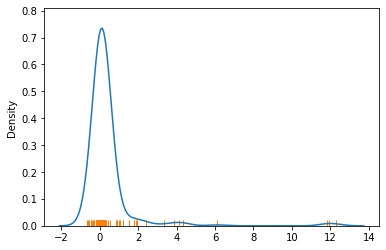

In [120]:
ax = seaborn.kdeplot(lisa.Is)
seaborn.rugplot(lisa.Is, ax=ax)

/opt/anaconda3/envs/sds2020/lib/python3.7/site-packages/contextily/tile.py:353: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  img.transpose(2, 0, 1), transform, "EPSG:3857", t_crs, resampling


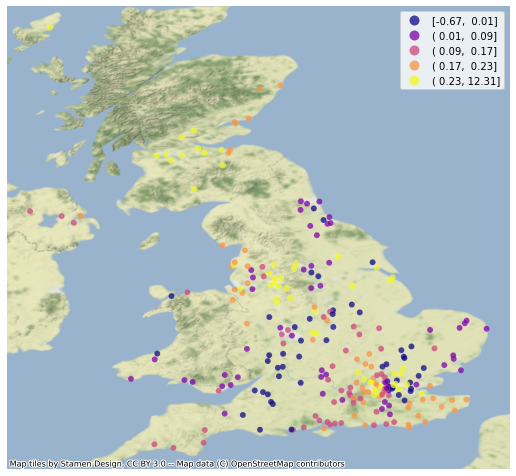

In [121]:
f, ax = plt.subplots(1, figsize=(9,9))
db['Is'] = lisa.Is
db.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True,ax=ax);
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

In [123]:
db

LAD13CD  latest_accounts_assets                   geometry    Is
0    E06000001              685,714.38  POINT (-1.20508 54.68696)  0.04
1    E06000002              635,493.88  POINT (-1.24254 54.56211)  0.03
2    E06000003              674,810.25  POINT (-1.18402 54.57528)  0.04
3    E06000004              471,172.62  POINT (-1.31463 54.63242) -0.00
4    E06000005              748,059.25  POINT (-1.56140 54.52265)  0.05
..         ...                     ...                        ...   ...
259  W06000014               24,461.00  POINT (-3.26824 51.45128)  0.10
260  W06000015              262,956.12  POINT (-3.20286 51.53716)  0.06
261  W06000019              252,931.12  POINT (-3.15461 51.74719)  0.08
262  W06000021              298,359.50  POINT (-2.91030 51.70445)  0.05
263  W06000022              282,676.62  POINT (-3.04476 51.55837)  0.04

[264 rows x 4 columns]

In [147]:
db_geo = pd.merge(localauth, db, how = 'right', on = 'LAD13CD')

In [148]:
len(db_geo)

264

In [149]:
#rename to use polygon otherwise would be points
db_geo = db_geo.rename(columns={'geometry_x': 'geometry'})

In [159]:
db_geo

LAD13CD LAD13CDO               LAD13NM       LAD13NMW  \
0    E06000001     00EB            Hartlepool           None   
1    E06000002     00EC         Middlesbrough           None   
2    E06000003     00EE  Redcar and Cleveland           None   
3    E06000004     00EF      Stockton-on-Tees           None   
4    E06000005     00EH            Darlington           None   
..         ...      ...                   ...            ...   
259  W06000014     00PD     Vale of Glamorgan  Bro Morgannwg   
260  W06000015     00PT               Cardiff       Caerdydd   
261  W06000019     00PL         Blaenau Gwent  Blaenau Gwent   
262  W06000021     00PP         Monmouthshire      Sir Fynwy   
263  W06000022     00PR               Newport      Casnewydd   

                                              geometry  \
0    MULTIPOLYGON (((-1.24196 54.72245, -1.24251 54...   
1    MULTIPOLYGON (((-1.19705 54.58178, -1.19436 54...   
2    MULTIPOLYGON (((-1.20099 54.57759, -1.20024 54...   
3    MULTIPOLYGON (((-1.30387 54.56514, -1.30199 54...   
4    POLYGON ((-1.63799 54.61719, -1.63766 54.61669...   
..                                                 ...   
259  MULTIPOLYGON (((-3.19541 51.39608, -3.19487 51...   
260  MULTIPOLYGON (((-3.11756 51.37547, -3.11788 51...   
261  POLYGON ((-3.24824 51.81515, -3.23877 51.81235...   
262  MULTIPOLYGON (((-2.78092 51.52605, -2.78124 51...   
263  MULTIPOLYGON (((-2.94667 51.62718, -2.94672 51...   

     latest_accounts_assets                 geometry_y    Is  
0                685,714.38  POINT (-1.20508 54.68696)  0.04  
1                635,493.88  POINT (-1.24254 54.56211)  0.03  
2                674,810.25  POINT (-1.18402 54.57528)  0.04  
3                471,172.62  POINT (-1.31463 54.63242) -0.00  
4                748,059.25  POINT (-1.56140 54.52265)  0.05  
..                      ...                        ...   ...  
259               24,461.00  POINT (-3.26824 51.45128)  0.10  
260              262,956.12  POINT (-3.20286 51.53716)  0.06  
261              252,931.12  POINT (-3.15461 51.74719)  0.08  
262              298,359.50  POINT (-2.91030 51.70445)  0.05  
263              282,676.62  POINT (-3.04476 51.55837)  0.04  

[264 rows x 8 columns]

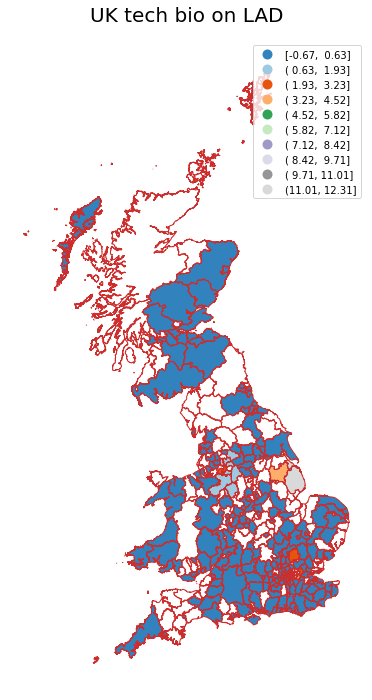

In [150]:
fig, ax = plt_ldn(localauth)
ax.set_axis_off()
ax.set_title('UK tech bio on LAD',fontsize=20, y=1.02)
db_geo.plot(column='Is', ax=ax, linewidth=0, zorder=2,
        legend=True, scheme='equalinterval', edgecolor='k',
        cmap='tab20c',k=10)
plt.savefig("Is")
plt.show()

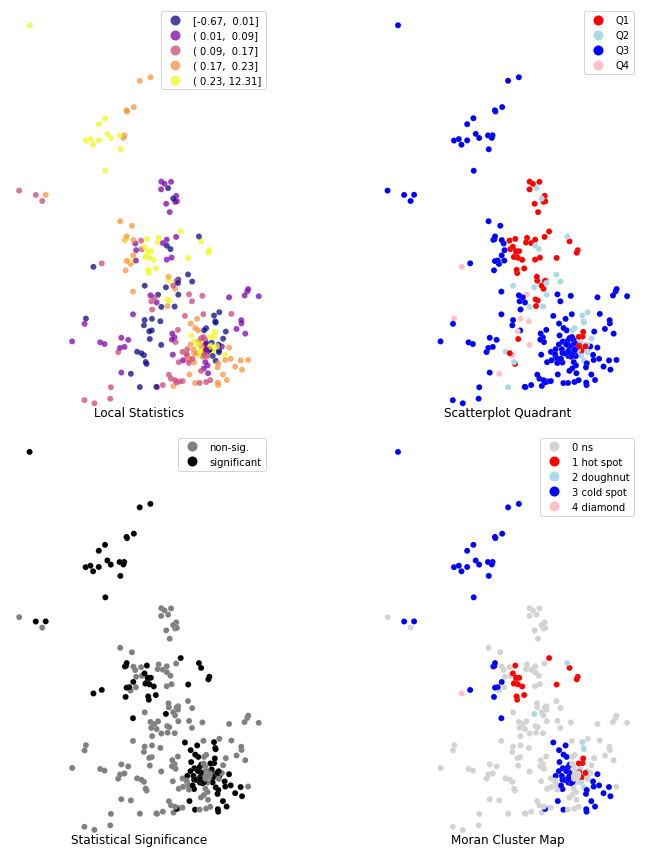

In [131]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
db.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = colors.ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                       
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])


db.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(['Local Statistics', 
                  'Scatterplot Quadrant', 
                  'Statistical Significance', 
                  'Moran Cluster Map'][i], y=0)

f.tight_layout()

# Display the figure
plt.show()

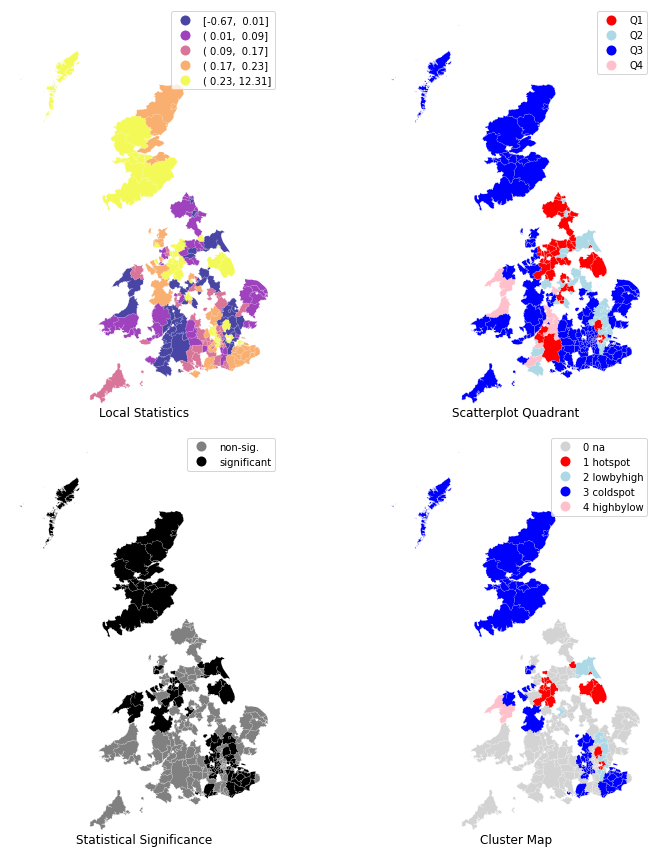

In [168]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

                    # Subplot 1 #
ax = axs[0]
db_geo.plot(column='Is', cmap='plasma', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0.1, alpha=0.75, legend=True, ax=ax)

                    # Subplot 2 #
ax = axs[1]
q_labels = ['Q1', 'Q2', 'Q3', 'Q4']
labels = [q_labels[i-1] for i in lisa.q]
hmap = colors.ListedColormap([ 'red', 'lightblue', 'blue', 'pink'])
db_geo.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                    # Subplot 3 #

ax = axs[2]
sig = 1 * (lisa.p_sim < 0.05)
hmap = colors.ListedColormap(['grey','black'])
labels = ['non-sig.', 'significant'] 
labels = [labels[i] for i in sig]
db_geo.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

                       
                    # Subplot 4 #
ax = axs[3]
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond
spot_labels = [ '0 na', '1 hotspot', '2 lowbyhigh', '3 coldspot', '4 highbylow']
labels = [spot_labels[i] for i in spots]
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])


db_geo.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(['Local Statistics', 
                  'Scatterplot Quadrant', 
                  'Statistical Significance', 
                  'Cluster Map'][i], y=0)

f.tight_layout()

# Display the figure
plt.show()

In [167]:
lisa.q[:25]

array([1, 1, 1, 2, 1, 3, 1, 3, 1, 2, 1, 1, 1, 2, 3, 2, 3, 1, 4, 2, 1, 3,
       3, 3, 3])

In [152]:
# Gi
gostats = esda.getisord.G_Local(db['latest_accounts_assets'], w)
# Gi*
gostars = esda.getisord.G_Local(db['latest_accounts_assets'], w, star=True)

In [157]:
def g_map(g, geog, ax):
    '''
    Create a cluster map
    ...
    
    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    geog   : GeoDataFrame
             Table aligned with values in `g` and containing 
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    '''
    ec = '0.8'
    
    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db_geo.loc[sig==False, 'geometry']
    ns.plot(ax=ax, color='lightgrey', edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db_geo.loc[(g.Zs > 0) & (sig==True), 'geometry']
    hh.plot(ax=ax, color='red', edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db_geo.loc[(g.Zs < 0) & (sig==True), 'geometry']
    ll.plot(ax=ax, color='blue', edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(ax, 
                           crs=db_geo.crs, 
                           source=contextily.providers.Stamen.TerrainBackground,

                          )
    st = ''
    if g.star:
        st = '*'
    ax.set_title(f'G{st} statistic for latest_accounts_assets', size=15)
    ax.set_axis_off()
    return ax

/opt/anaconda3/envs/sds2020/lib/python3.7/site-packages/contextily/tile.py:353: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  img.transpose(2, 0, 1), transform, "EPSG:3857", t_crs, resampling
/opt/anaconda3/envs/sds2020/lib/python3.7/site-packages/contextily/tile.py:353: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  img.transpose(2, 0, 1), transform, "EPSG:3857", t_crs, resampling


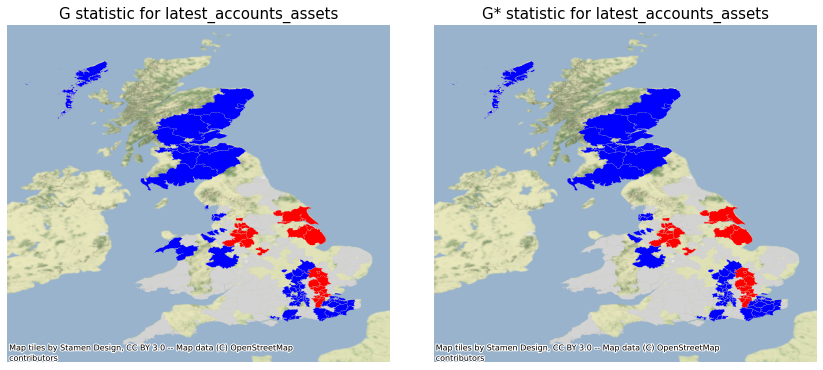

In [158]:
# Setup figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics and generate the map
for g, ax in zip([gostats, gostars], axs.flatten()):
    ax = g_map(g, db_geo, ax)
f.tight_layout()
# Render
plt.show()

In [170]:
db_geo['latest_accounts_assets_lag'] = weights.spatial_lag.lag_spatial(w, db_geo['latest_accounts_assets'])

In [174]:
db_geo['latest_accounts_assets_std'] = ( db_geo['latest_accounts_assets'] - db_geo['latest_accounts_assets'].mean() )\
                    / db_geo['latest_accounts_assets'].std()
db_geo['latest_accounts_assets_lag_std'] = ( db_geo['latest_accounts_assets_lag'] - db_geo['latest_accounts_assets_lag'].mean() )\
                    / db_geo['latest_accounts_assets_lag'].std()

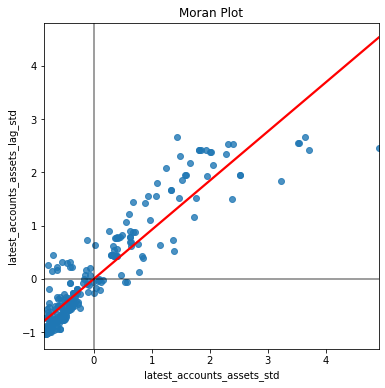

In [187]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(x='latest_accounts_assets_std', y='latest_accounts_assets_lag_std', 
                ci=None, data=db_geo, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot')
plt.show()

In [177]:
w.transform = 'R'
moran = esda.moran.Moran(db_geo['latest_accounts_assets'], w)

In [178]:
moran.I

0.7300851749594152

In [179]:
moran.p_sim

0.001

In [182]:
from pysal.viz import splot
from splot.esda import plot_moran
from numpy.random import seed

(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.73', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.73)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

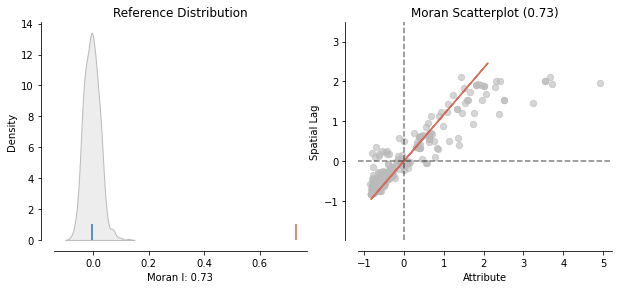

In [183]:
plot_moran(moran)

In [184]:
geary = esda.geary.Geary(db_geo['latest_accounts_assets'], w)

In [185]:
geary.C

0.21610367761855126

In [186]:
geary.p_sim

0.001

## mthd one gwr

In [15]:
coordinates = np.column_stack([tech_asset_bio.lat,
                                  tech_asset_bio.long])

In [16]:
coordinates

array([[57.142706, -2.121642],
       [57.188517, -2.176935],
       [57.144642, -2.117005],
       ...,
       [53.97683 , -1.110057],
       [54.010751, -1.058198],
       [53.928411, -0.782959]])

In [17]:
# ' + standardize(nr_employees_last_avail_yr)' change the object to float64
y,X = patsy.dmatrices('standardize(latest_accounts_assets) ~ 0 + standardize(age)' '+ standardize(nr_employees_last_avail_yr)', data = tech_asset_bio)
#y = np.log(tech_asset_bio['latest_accounts_assets'].values.reshape((-1, 1)))
#X = tech_asset_bio[['age','nr_employees_last_avail_yr']].values

In [18]:
bw = mgwr.sel_bw.Sel_BW(coordinates,
                       np.asarray(y),
                       np.asarray(X),
                       fixed = False,
                       spherical= True)

In [19]:
bw.search()

64.0

In [20]:
model = GWR(coordinates,
                    np.asarray(y),
                    np.asarray(X),
                    bw.bw[0])

In [21]:
results = model.fit()

In [22]:
with open('LAD1.geojson', encoding="UTF-8") as json_file:
    LAD_json = json.load(json_file)

In [23]:
gdf = gpd.GeoDataFrame(tech_asset_bio, 
      geometry=gpd.points_from_xy(tech_asset_bio['long'], tech_asset_bio['lat'], crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

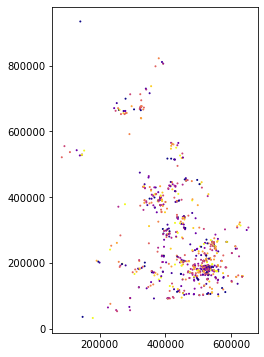

In [24]:
gdf.plot(column='latest_accounts_assets', cmap='plasma', scheme='quantiles', k=11, markersize=1, figsize=(12,6));

In [25]:
#img,bounds = ctx.bounds2img(*tech_asset_bio.total_bounds,  zoom=12, url=ctx.tile_providers.ST_Toner_LITE)

In [26]:
#tech_asset_bio2 = tech_asset_bio.dropna(subset=('latest_accounts_assets','nr_employees_last_avail_yr','age'), inplace=True)
#tech_asset_bio2 = tech_asset_bio[['latest_accounts_assets','nr_employees_last_avail_yr','age']]

In [27]:
tech_asset_bio3 = tech_asset_bio[['latest_accounts_assets','nr_employees_last_avail_yr','age','oslaua']]

In [28]:
#rename column to match
tech_asset_bio3=tech_asset_bio3.rename(columns={"oslaua": "LAD13CD"})

In [29]:
len(tech_asset_bio3)

894

Downloaded localauth.json file.


In [69]:
rs = pd.merge(localauth, tech_asset_bio3, how="right", on=["LAD13CD"])

In [70]:
len(rs)

894

In [33]:
rs["age"] = results.params[:, 1]
rs["nr_employees_last_avail_yr"] = results.params[:, 2]

f, ax = plt.subplots(1,3,figsize=(12,3), subplot_kw=dict(aspect='equal'))
for i,ax_ in enumerate(ax):

    tech_asset_bio2.plot(color='grey', marker='.', ax=ax_)
    
    (tech_asset_bio2.assign(localweight=model.W[i])#it is not tech_asset_bio2 does not have spatial
      .query('localweigtht>0')
      .sort_values('localweight')
      .plot('localweight',ax=ax_, cmap='plasma',marker =".",legend=True))
    

    ax_.set_xticks([])
    ax_.set_xticklabels([])
    ax_.set_yticks([])
    ax_.set_yticklabels([])
    
    ax_.set_title("weight on data {}" .format(i+1))
    
f.tight_layout()
plt.show()

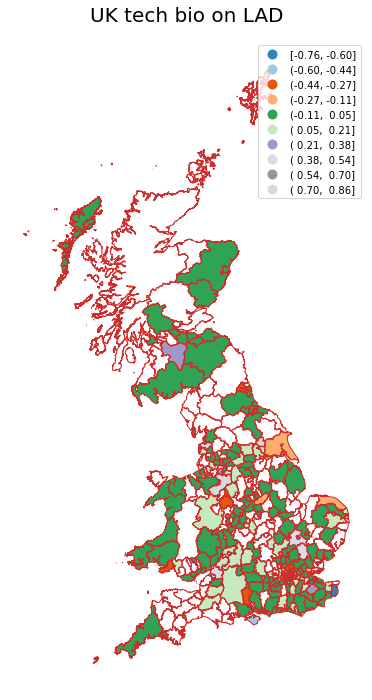

In [35]:
fig, ax = plt_ldn(localauth)
ax.set_axis_off()
ax.set_title('UK tech bio on LAD',fontsize=20, y=1.02)
rs.plot(column='age', ax=ax, linewidth=0, zorder=2,
        legend=True, scheme='equalinterval', edgecolor='k',
        cmap='tab20c',k=10)
plt.savefig("age_bio2")
plt.show()

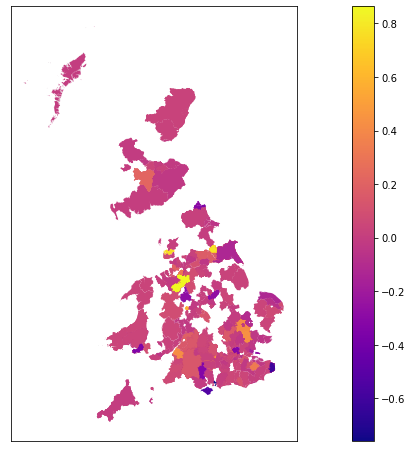

In [36]:
rs.plot("age",figsize=(20,8),cmap='plasma',legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig("age_bio")
plt.show()

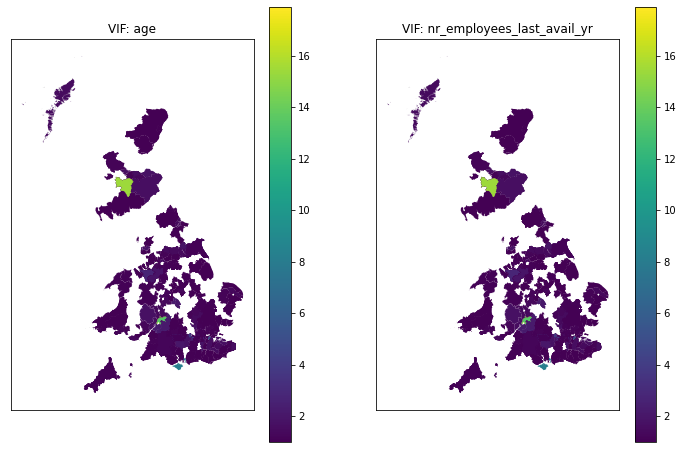

In [37]:
LCC, VIF, CN, VDP = results.local_collinearity()
names = ["age", "nr_employees_last_avail_yr"]
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
for col in range(2):
    rs["VIF"] = VIF[:, col]
    rs.plot("VIF", ax = ax[col], legend = True)
    ax[col].set_title("VIF: " + names[col])
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)


Text(0.5, 1.0, 'nr_employees_last_avail_yr')

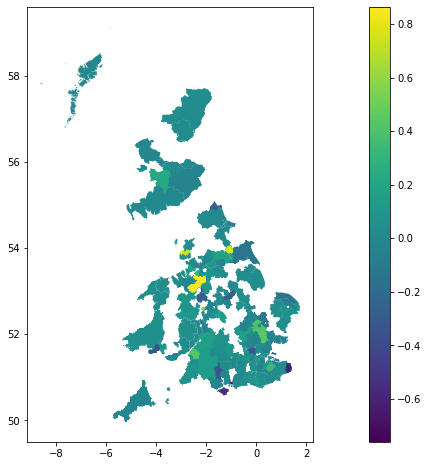

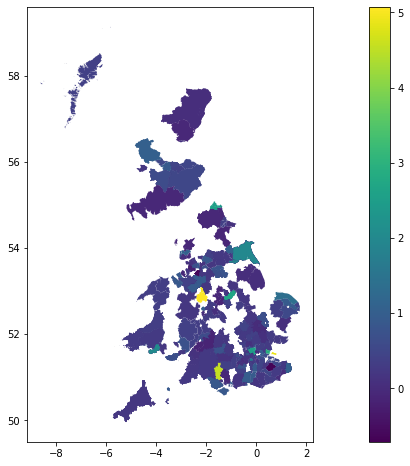

In [38]:
rs.plot("age",figsize=(20,8),legend = True)

rs.plot("nr_employees_last_avail_yr",figsize=(20,8),legend = True)
ax[col].set_title(names[col])
ax[col].set_title(names[col])

In [40]:
print(results.resid_ss)

print(results.aic)

print(results.aicc)

print(results.R2)

NameError: name 'results' is not defined

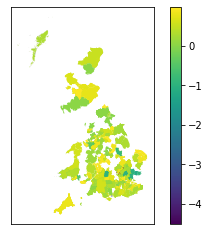

In [40]:
rs["R2"] = results.localR2
rs.plot("R2", legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig("age_R2")
plt.show()

In [41]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                                 894
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            387.873
Log-likelihood:                                                    -895.274
AIC:                                                               1796.548
AICc:                                                              1798.593
BIC:                                                              -5667.100
R2:                                                                   0.566
Adj. R2:                                                              0.565

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [326]:
tech=pd.read_csv('tech_SIC_geo.csv')

/opt/anaconda3/envs/sds2020/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (3,5,28,41,66) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [327]:
tech = tech.fillna(0)
#remove missing geo
tech = tech[tech.lat != 0]

In [328]:
#string dect filter guo_bvd_id with cn
tech['IN'] = tech.guo_bvd_id.str.contains('IN', regex = False)

In [329]:
tech['IN']

1187      False
1188      False
1189      False
1190      False
1191      False
          ...  
319619    False
319620    False
319621    False
319622    False
319623    False
Name: IN, Length: 311868, dtype: bool

In [330]:
tech.drop(tech[(tech['IN'] == False)].index, axis=0, inplace=True)

In [331]:
tech

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1 registered_number  \
1222          1222       1021475         1021475          SC564281   
1245          1245       1023278         1023278          SC412622   
1412          1412       1031033         1031033          SC594101   
1420          1420       1031231         1031231          SC632235   
1646          1646       1040353         1040353          SC633108   
...            ...           ...             ...               ...   
317942      317942      11741180        11741180          08964018   
318328      318328      11754262        11754262          01956183   
318741      318741      11773453        11773453          03033290   
319051      319051      11785428        11785428          07900460   
319173      319173      11789971        11789971          11648702   

       incorporation_date dissolution_date  latest_accounts_cash  \
1222           2017-04-25                0                  0.00   
1245           2011-12-05                0                  0.00   
1412           2018-04-11                0                  0.00   
1420                    0                0                  0.00   
1646                    0                0                  0.00   
...                   ...              ...                   ...   
317942         2014-03-27                0                  0.00   
318328         1985-11-08                0                  0.00   
318741         1995-03-09                0                  0.00   
319051         2012-01-06                0                  0.00   
319173         2018-10-29                0                  0.00   

        latest_accounts_assets  latest_accounts_liabilities  year_obs  ...  \
1222                      0.00                         0.00      2018  ...   
1245                 43,230.00                         0.00      2017  ...   
1412                      0.00                         0.00      2018  ...   
1420                      0.00                         0.00      2018  ...   
1646                      0.00                         0.00      2018  ...   
...                        ...                          ...       ...  ...   
317942              141,830.00                         0.00      2018  ...   
318328                    0.00                         0.00      2018  ...   
318741                    0.00                         0.00      2018  ...   
319051               70,938.00                         0.00      2018  ...   
319173                    0.00                         0.00      2018  ...   

             ctry        rgn       ttwa        pct       lep1       lep2  \
1222    S92000003  S99999999  S22000047  S03000012  S99999999  S99999999   
1245    S92000003  S99999999  S22000047  S03000012  S99999999  S99999999   
1412    S92000003  S99999999  S22000047  S03000012  S99999999  S99999999   
1420    S92000003  S99999999  S22000047  S03000012  S99999999  S99999999   
1646    S92000003  S99999999  S22000047  S03000013  S99999999  S99999999   
...           ...        ...        ...        ...        ...        ...   
317942  E92000001  E12000005  E30000288  E16000072  E37000001          0   
318328  E92000001  E12000003  E30000259  E16000099  E37000039          0   
318741  E92000001  E12000003  E30000294  E16000099  E37000020  E37000039   
319051  E92000001  E12000003  E30000294  E16000099  E37000020  E37000039   
319173  E92000001  E12000003  E30000294  E16000099  E37000020  E37000039   

           oslaua   lat  long    IN  
1222    S12000033 57.15 -2.10  True  
1245    S12000033 57.15 -2.12  True  
1412    S12000033 57.15 -2.09  True  
1420    S12000033 57.15 -2.08  True  
1646    S12000034 57.06 -2.14  True  
...           ...   ...   ...   ...  
317942  E08000031 52.59 -2.16  True  
318328  E07000168 54.24 -0.40  True  
318741  E06000014 53.95 -1.09  True  
319051  E06000014 53.99 -1.10  True  
319173  E06000014 53.96 -1.07  True  

[6851 rows x 71 columns]

tech.to_csv("ethinic_cn.csv")

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(tech.long, tech.lat, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on UK Map')

In [332]:
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
MarkerCluster()

In [333]:
#select coloumn needs two open brackets
to_map_tech = tech[['registered_number','lat','long']]
#need to delete rows of missing value of lat long, or it gets keyerror 0 in popup

In [334]:
to_map_tech

registered_number   lat  long
1222            SC564281 57.15 -2.10
1245            SC412622 57.15 -2.12
1412            SC594101 57.15 -2.09
1420            SC632235 57.15 -2.08
1646            SC633108 57.06 -2.14
...                  ...   ...   ...
317942          08964018 52.59 -2.16
318328          01956183 54.24 -0.40
318741          03033290 53.95 -1.09
319051          07900460 53.99 -1.10
319173          11648702 53.96 -1.07

[6851 rows x 3 columns]

In [335]:
locations = to_map_tech[['lat', 'long']]
locationlist = locations.values.tolist()
len(locationlist)

6851

In [336]:
locationlist[100]

[52.4906, -1.911473]

map = folium.Map(location=[55, 4], zoom_start=5)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map)
map

map = folium.Map(location=[55, 4], zoom_start=5)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=to_map_tech['registered_number'][point]).add_to(map)
map

In [337]:
#new undeprecated way
LAD_map = folium.Map(location=[55, 4], zoom_start=5)
marker_cluster = folium.plugins.MarkerCluster().add_to(LAD_map)
# generate points map

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)

LAD_map

LAD_map.save("LAD_map_DE.html")

In [55]:
#google mobility score

In [56]:
#speculation: say that as tech clustered in London while mobility changes dramatically would lead to blablabla

In [57]:
#cross validation

In [58]:
#sensitivity analysis